#Sociology of the Digital Public Space - Group Research - MODEL


This notebook aims at providing a algorithm which enables to classify tweets between anstisemitic and non antisemitic. The analysis will be in english only because of the richer resources of NLP in english and the origin of the training dataset

In [ ]:
# author: Anthammax https://github.com/anthammax
# date: 28/11/2023
# last_update : 29/11/2023, 12:00:00

## Imports

In [ ]:
%%capture
## Install (once)
!pip install transformers
!pip install evaluate
!pip install datasets
!pip install keras-tcn
!pip install transformers[torch]

In [ ]:
## Libraries

# Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cleaning
import re

# Evaluation, metrics, others
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from datasets import Dataset, DatasetDict

# Models
from sklearn import svm, ensemble
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer


# Deep learning
import tensorflow as tf
import pickle
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import callbacks, Sequential, regularizers, layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model #import model

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Input, Dense, LSTM, Dropout,Embedding, concatenate,SpatialDropout1D,GlobalAveragePooling1D, GlobalMaxPooling1D

from tensorflow.python.keras.models import Input

import tcn
from tcn import TCN, tcn_full_summary

from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Models

def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=['the', 'a', 'and', 'is', 'be', 'will']) -> str:
    """
    A method to clean text
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string

def create_embedding_matrix(path, vector_dimension, tokenizer, max_features):
  """
  A method to create the embedding matrix
  """
  def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


  model_embed = dict(get_coefs(*o.split(" ")) for o in open(path, errors='ignore'))

  embedding_matrix = np.zeros((max_features + 1, vector_dimension))
  for word, index in tokenizer.word_index.items():
    if index > max_features:
       break
    else:
       try:
         embedding_matrix[index] = model_embed[word]
       except:
         continue
  return embedding_matrix

def string_to_tensor(tokenizer, max_len, string_list: list) -> list:
  """
  A method to convert a string list to a tensor for a deep learning model
  """
  string_list = tokenizer.texts_to_sequences(string_list)
  string_list = pad_sequences(string_list, maxlen=max_len)

  return string_list

## Evaluation

def conf_matrix(y_pred,y_val):
  """
  Print a nice confusion matrix
  """
  title="Confusion Matrix"
  conf_matrix = confusion_matrix(y_pred,y_val,labels=[1,0])
  fig, ax = plt.subplots(1,1,figsize=(7,4))
  disp = ConfusionMatrixDisplay(conf_matrix,display_labels=['antisemitic tweet','non antisemitic tweet']).plot(values_format=".0f",ax=ax , cmap=plt.cm.Blues)

  ax.set_xlabel("True Label")
  ax.set_ylabel("Predicted Label")
  plt.title(title)
  plt.show()

def metrics(y_pred,y_val):
  """
  Print all basics metrics and return the values
  """
  conf_matrix = confusion_matrix(y_pred,y_val,labels=[1,0])
  TP = conf_matrix[0][0]
  FP = conf_matrix[0][1]
  TN = conf_matrix[1][1]
  FN = conf_matrix[1][0]
  tot = TP+FP+TN+FN

  acc = round((TP+TN)/tot*100,2)
  er = round(100-acc,2)
  recall = round(TP/(TP+FN)*100,2) #quantity :high recall means that the algorithm returns most of the relevant results
  precision = round(TP/(TP+FP)*100,2) #measure of the quality
  f1 = round(f1_score(y_pred, y_val)*100,2) #trade-off btw recall and precision

  print("-------- Metrics ----------")
  print("Accuracy   :",acc,'%')
  print("Error rate :",er,'%')
  print("Recall     :",recall,'%')
  print("Precision  :",precision,'%')
  print("f1         :",f1,'%')
  print("----------------------------")

  return [acc,er,recall,precision,f1]

## Import Data

In [9]:
#data to predict
dataset = pd.read_csv('//content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Data Analysis/FINAL_tweet.csv') #Merged dataset

<ipython-input-9-694fab6cd90a>:2: DtypeWarning: Columns (18,24,26,40) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('//content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Data Analysis/FINAL_tweet.csv') #Merged dataset


**Data for training the model**
* [Link](https://data.world/anthammax/tweet/workspace/project-summary?agentid=crowdflower&datasetid=hate-speech-identification) to download the data and to have access to the scholar

* [Link](https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv) to the github to download the data and understand the dataset

In [10]:
len(dataset[dataset.lang == 'en'])

158439

In [ ]:
# data labeled for the training
data_train = pd.read_csv('/content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Model/labeled_data.csv')
data_train['label'] = data_train['class'].map({0: 0, 1: 1, 2:0})
data_train = data_train[['label','tweet']]

# Model - Long Short Term Memory (LSTM)


The implementation is inspiring by one of my last work on a close topic, available [HERE](https://colab.research.google.com/drive/1AM21xAgZhnXAO_dUROs0ZY99V1HejHZS?usp=sharing#scrollTo=Ofqy0c6oRwqj)

## Preprocessing
We start from scratch with the brut tweets (in data_train) because we have to deal with another type of tokenization which is more accurate.
So first, let's clean the data as usual
[Source](https://towardsdatascience.com/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81)

In [ ]:
text = data_train['tweet'].tolist()
target  = data_train['label'].tolist()

In [ ]:
## Clean the text
X = [clean_text(text) for text in text]
Y = np.asarray(target)

In [ ]:
## Split in train and val
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

In [ ]:
## Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #compute the token in intern memory

In [ ]:
## Creating the embedding matrix

#path_300d = '/content/drive/MyDrive/FDA_Challenge/Models/glove/glove.840B.300d.txt'
path_50d = '/content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Model/glove/glove.twitter.27B.50d.txt'

max_features = len(tokenizer.word_counts)

#embedding_matrix_300d = create_embedding_matrix(path_300d, 300 , tokenizer, max_features) #another possibility more compelex
embedding_matrix_50d = create_embedding_matrix(path_50d, 50, tokenizer, max_features)

In [ ]:
# Creating the padded input for the deep learning model
max_len = np.max([len(text.split()) for text in X_train])
X_train = string_to_tensor(tokenizer, max_len,X_train)

## Training

In [ ]:
## The model

def get_model_LSTM2(embedding_matrix, embedding_dim):

  # build the model
  model = Sequential()
  model.add(Embedding(embedding_matrix.shape[0],embedding_dim, weights = [embedding_matrix], trainable=True))
  model.add(Bidirectional(LSTM(25, dropout=0.1)))
  model.add(Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(0.1))
  model.add(Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.1))
  model.add(Dense(2,activation = 'sigmoid'))

  # compile
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(
      optimizer = optimizer,
      loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
  )

  return model

In [ ]:
## Create the model

embedding_dim = 50

model_LSTM2 = get_model_LSTM2(embedding_matrix_50d, embedding_dim)
model_LSTM2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          1635750   
                                                                 
 bidirectional_1 (Bidirecti  (None, 50)                15200     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                      

In [ ]:
## callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3,
                                                  patience=2, verbose=1, min_lr=1e-7)
acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0,
                                              patience=10, verbose=2,
                                              mode='auto', restore_best_weights=True)

callbacks = [reduce_lr, acc]

In [ ]:
## Training
y_train = to_categorical(Y_train)
x_val = string_to_tensor(tokenizer, embedding_dim, X_val)
y_val = to_categorical(Y_val)

model_LSTM2.fit(
    X_train, y_train,
    validation_data=(x_val, y_val),
    batch_size = 32,
    epochs = 50,
    callbacks = callbacks)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


620/620 [==============================] - 49s 68ms/step - loss: 0.8152 - accuracy: 0.7738 - precision: 0.7783 - recall: 0.7658 - val_loss: 0.6373 - val_accuracy: 0.7997 - val_precision: 0.7954 - val_recall: 0.8069 - lr: 1.0000e-04
Epoch 2/50
620/620 [==============================] - 44s 70ms/step - loss: 0.5578 - accuracy: 0.8412 - precision: 0.8400 - recall: 0.8429 - val_loss: 0.4718 - val_accuracy: 0.8720 - val_precision: 0.8694 - val_recall: 0.8755 - lr: 1.0000e-04
Epoch 3/50
620/620 [==============================] - 41s 66ms/step - loss: 0.4470 - accuracy: 0.8670 - precision: 0.8689 - recall: 0.8646 - val_loss: 0.4002 - val_accuracy: 0.8829 - val_precision: 0.8819 - val_recall: 0.8842 - lr: 1.0000e-04
Epoch 4/50
620/620 [==============================] - 42s 68ms/step - loss: 0.3888 - accuracy: 0.8781 - precision: 0.8810 - recall: 0.8743 - val_loss: 0.3634 - val_accuracy: 0.8856 - val_precision: 0.8844 - val_recall: 0.8872 - lr: 1.0000e-04
Epoch 5/50
620/620 [===================

## Evaluation

In [ ]:
## Prediction
X_val_tensor = string_to_tensor(tokenizer, max_len,X_val)
yhat = [x[0] for x in model_LSTM2.predict(X_val_tensor).tolist()]
y_pred_LSTM2 = np.array([1 if x < 0.5 else 0 for x in yhat])

155/155 [==============================] - 2s 7ms/step


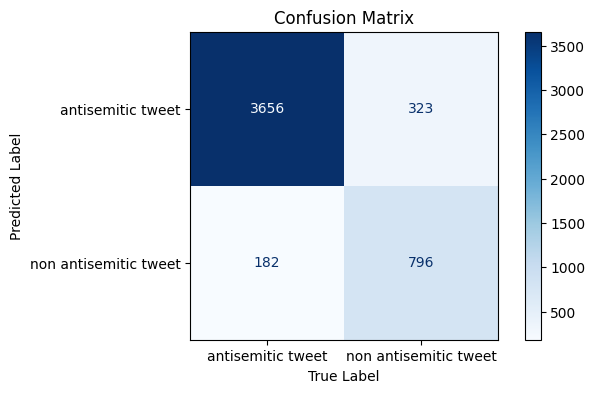

-------- Metrics ----------
Accuracy   : 89.81 %
Error rate : 10.19 %
Recall     : 95.26 %
Precision  : 91.88 %
f1         : 93.54 %
----------------------------


In [ ]:
## Evaluation
conf_matrix(y_pred_LSTM2,Y_val)
results_LSTM2 = metrics(y_pred_LSTM2,Y_val)

In [ ]:
## Save Model
model_LSTM2.save('/content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Model/model_LSTM2')

#Application

In [ ]:
## Load Model
model = load_model('/content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Model/model_LSTM2')

In [ ]:
# Tokenization
## Design the tokenizer to use
text = data_train['tweet'].tolist()
target  = data_train['label'].tolist()
X = [clean_text(text) for text in text]
Y = np.asarray(target)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) #compute the token in intern memory


## Import
data_sub = dataset[dataset.lang == 'en']['text'] # in english, only text
text = data_sub.tolist()
X = [clean_text(text) for text in text]
max_len = np.max([len(text.split()) for text in X_train])

X_tensor = string_to_tensor(tokenizer, max_len, X) # Do the tokenization

# Prediction
yhat = [x[0] for x in model.predict(X_tensor).tolist()] # brut result
y_pred = np.array([1 if x < 0.5 else 0 for x in yhat])

4952/4952 [==============================] - 50s 10ms/step


In the new dataset, with english tweets only, the column ```antisemitic``` is ```1``` is the tweet has been classified as antisemitic, else ```0```



In [ ]:
# update the dataset, now labeled
data_label = dataset[dataset.lang == 'en'].copy()
data_label =data_label.reset_index()
result = pd.DataFrame(y_pred, columns=['antisemitic'])
data_label['antisemitic'] = result.antisemitic

All tweet containing the ponctuation "((( )))", called the "echo" are manually flagged as antisemitic.
Indeed, a study from [Eyal Arviv, Simo Hanouna and Oren Tsur](https://ojs.aaai.org/index.php/ICWSM/article/view/18041/17844) has shown the importance of the echo in antisemitic tweets and hateful speech in general.

In [ ]:
data_label.antisemitic.mask((data_label.text.str.contains("\(\(\(")) & (data_label.antisemitic == 0), 1, inplace=True)

In [ ]:
# Save the work
data_label.to_csv(
       '//content/drive/Shareddrives/Group 3 - Sociology of Digital Public Spaces /Data/Data Analysis/Data_label.csv',
      index=False
  )